In [13]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gwdet
from pdet import VT_pop_uniform_q
from comp_pdet import pdet, snr
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [2]:
pdet(1, 1, 7e-2, n_samples=1e4)

1.0

In [3]:
z_min_compute = 7e-2 # Minimum value of z for which pdet can be < 1 for a q=1, M=2 BHB, using n_samples=1e4

m1grid = np.linspace(1, 100, 30)
m2grid = np.linspace(1, 100, 30)
zgrid = np.concatenate((np.geomspace(1e-4, 1, 100, endpoint=False), np.linspace(1, 10, 100)))

grids = (m1grid, m2grid, zgrid)
pdet_for_interpolation = np.zeros([len(grid) for grid in grids])

In [4]:
m1grid = np.geomspace(1, 100, 30)
m2grid = np.geomspace(1, 100, 30)
zgrid = np.concatenate((np.geomspace(1e-4, 1e-2, 30, endpoint=False), np.geomspace(1e-2, 10, 30)))

grids = (m1grid, m2grid, zgrid)
pdet_for_interpolation = np.zeros([len(grid) for grid in grids])

In [5]:
meshcoord = []
meshgrid = []
for i, m1 in enumerate(m1grid):
        for j, m2 in enumerate(m2grid):
            for k, z in enumerate(zgrid):
                if z <= z_min_compute:
                    pdet_for_interpolation[i, j, k] = 1
                else:
                    meshcoord.append((i, j, k))
                    meshgrid.append((m1 ,m2, z))

meshcoord = np.array(meshcoord)
meshgrid = np.array(meshgrid)

# Shuffle the arrays to better ditribute load across processors
p = np.random.permutation(len(meshcoord))

meshcoord = meshcoord[p]
meshgrid = meshgrid[p]

In [6]:
meshcoord.shape

(18900, 3)

In [7]:
meshvalues = np.array(Parallel(n_jobs=-1, verbose=11)(delayed(pdet)(m1, m2, z, n_samples=1e2, n_jobs=1) for m1, m2, z in meshgrid))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

In [10]:
for ijk, val in zip(meshcoord, meshvalues):
    pdet_for_interpolation[*ijk] = val

In [55]:
pdet_interpolant = RegularGridInterpolator(grids, pdet_for_interpolation)

In [21]:
interpolated_pdet(np.array([[10, 10, 1],
                           [24, 37, 5]]))

array([0.97852874, 0.50221642])

In [47]:
m1_test = np.random.uniform(1, 100, 1000)
m2_test = np.random.uniform(1, 100, 1000)
z_test = np.concatenate((10 ** np.random.uniform(-2, 1, 500), np.random.uniform(1, 10, 500)))

In [56]:
interpolated_pdet = pdet_interpolant(np.vstack((m1_test, m2_test, z_test)).T)

In [48]:
pdet_test = np.array(Parallel(n_jobs=-1, verbose=11)(delayed(pdet)(m1, m2, z, n_samples=1e2, n_jobs=1) for m1, m2, z in zip(m1_test, m2_test, z_test)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

/tmp/ipykernel_3385199/1715126828.py:1: RuntimeWarning: divide by zero encountered in divide
  rel_err = (interpolated_pdet - pdet_test) / pdet_test
/tmp/ipykernel_3385199/1715126828.py:1: RuntimeWarning: invalid value encountered in divide
  rel_err = (interpolated_pdet - pdet_test) / pdet_test


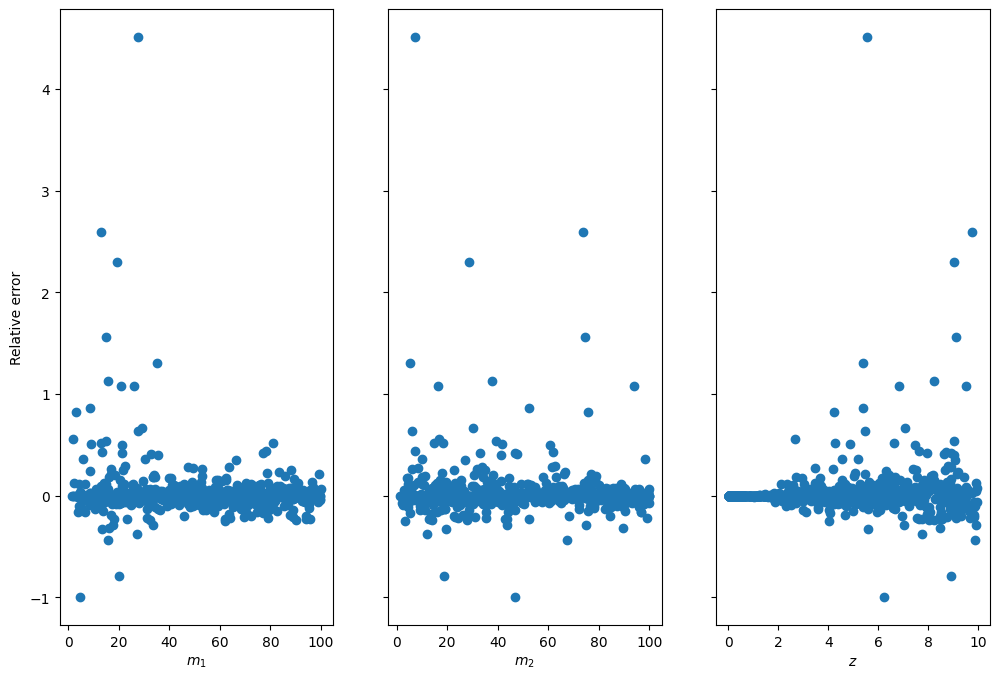

In [68]:
rel_err = (interpolated_pdet - pdet_test) / pdet_test

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8), sharey=True)

for ax, grid, xlb in zip(axes, (m1_test, m2_test, z_test), (r'$m_1$', r'$m_2$', r'$z$')):
    ax.scatter(grid, rel_err)
    ax.set_xlabel(xlb)
axes[0].set_ylabel('Relative error')

plt.show()

In [5]:
m1_min, m1_max, m1_len = 1, 100, 100
q = 0.8 # m2 / m1, with m2 <= m1. Below q = 0.3 plots become a bit messy
z_min, z_max, z_len = 1e-4, 2.2, 50
m1 = np.linspace(1, 100, m1_len)
m2 = m1 * q
z = np.linspace(1e-4, 2.2, z_len)

In [6]:
p = gwdet.detectability()

In [7]:
# with open('data/18213_ET10kmcolumns.txt', 'r') as file:
#     new_lines = []
#     while True:
#         line = file.readline()
#         if line == '':
#             break
#         else:
#             line = line.split(' ')
#             new_lines.append(line[0] + ' ' + line[3])

# with open('data/ET_ASD_file.txt', 'x') as file:
#     file.writelines(new_lines)

In [8]:
with open('data/ET_ASD_file.txt', 'r') as file:
    lines = file.readlines()

f = np.zeros(len(lines))
for i, line in enumerate(lines):
    f[i] = float(line.split(' ')[0])

delta_f = f[1:] - f[:-1]

In [9]:
np.min(delta_f)

np.float64(0.0030758579429499555)

In [10]:
# p = gwdet.detectability(directory='data/', psd_from_path=True, psd_path='data/ET_ASD_file.txt', is_asd_file=True,
#                         flow=1., deltaf=1 / 40, snrthreshold=8., massmin=1, massmax=200, zmin=1e-4, zmax=2.2)

In [11]:
p_det = np.zeros((z_len, m1_len))

for i, _z in enumerate(z):
    p_det[i] = p(m1, m2, np.zeros(m1_len) + _z)

In [12]:
np.sum(p_det < 0)

np.int64(0)

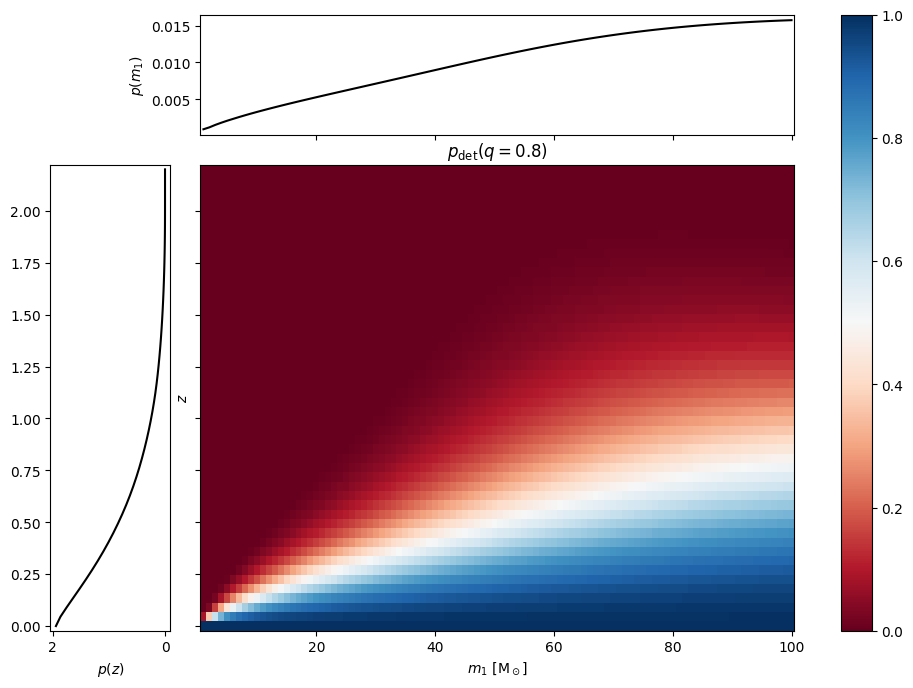

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
divider = make_axes_locatable(ax)

ax_m = divider.append_axes('top', 1.2, pad=0.3, sharex=ax)
ax_z = divider.append_axes('left', 1.2, pad=0.3, sharey=ax)

ax.tick_params(labelleft=False)
ax_m.tick_params(labelbottom=False)

ax.set_title(r'$p_\text{{det}} (q = {0})$'.format(q))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['RdBu']
im = ax.pcolormesh(m1, z, p_det, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))

fig.colorbar(im, ax=ax)

ax_m.set_ylabel(r'$p(m_1)$')

ax_m.plot(m1, np.sum(p_det, axis=0) / np.trapezoid(np.sum(p_det, axis=0), m1), color='black')

ax_z.set_xlabel(r'$p(z)$')

ax_z.xaxis.set_inverted(True)

ax_z.plot(np.sum(p_det, axis=1) / np.trapezoid(np.sum(p_det, axis=1), z), z, color='black')

plt.show()

In [14]:
if __name__ == '__main__':
    VT = VT_pop_uniform_q(1, z, m1, q)

Computing VT for each (m, z) pair for a uniformly distributed population of sources with fixed q = 0.8:   0%| …

In [15]:
np.sum(VT < 0)

np.int64(0)

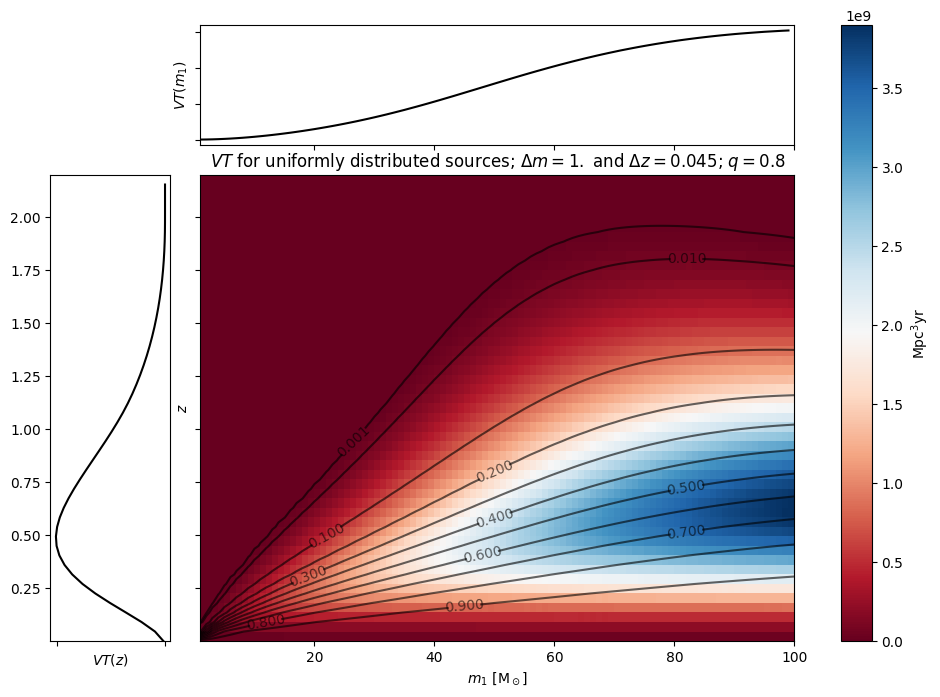

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

divider = make_axes_locatable(ax)

ax_m = divider.append_axes('top', 1.2, pad=0.3, sharex=ax)
ax_z = divider.append_axes('left', 1.2, pad=0.3, sharey=ax)

ax.tick_params(labelleft=False)
ax_m.tick_params(labelbottom=False, labelleft=False)
ax_z.tick_params(labelbottom=False)

ax.set_title(r'$VT$ for uniformly distributed sources; $\Delta m = {0}$ and $\Delta z = {1}$; $q = {2}$'.format(np.format_float_positional((m1_max - m1_min) / (m1_len - 1), 3),
                                                                                                                np.format_float_positional((z_max - z_min) / (z_len - 1), 3),
                                                                                                                np.format_float_positional(q, 3)))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

# VT heatmap
cmap = plt.colormaps['RdBu']
im = ax.pcolormesh(m1, z, VT, cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(VT), vmax=np.max(VT)))

# pdet contour levels
levels = [1e-3, 1e-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cf = ax.contour(m1, z, p_det, levels=levels, colors='black', alpha=0.6)
ax.clabel(cf)

cbar = fig.colorbar(im, ax=ax, label=r'$\text{Mpc}^3 \text{yr}$')

ax_m.set_ylabel(r'$VT(m_1)$')

ax_m.plot(m1[:-1], np.sum(VT, axis=0), color='black')

ax_z.set_xlabel(r'$VT(z)$')

ax_z.xaxis.set_inverted(True)

ax_z.plot(np.sum(VT, axis=1), z[:-1], color='black')

plt.show()

/tmp/ipykernel_3228209/3420535131.py:8: RuntimeWarning: divide by zero encountered in divide
  VT_ratio_map = target_VT / VT


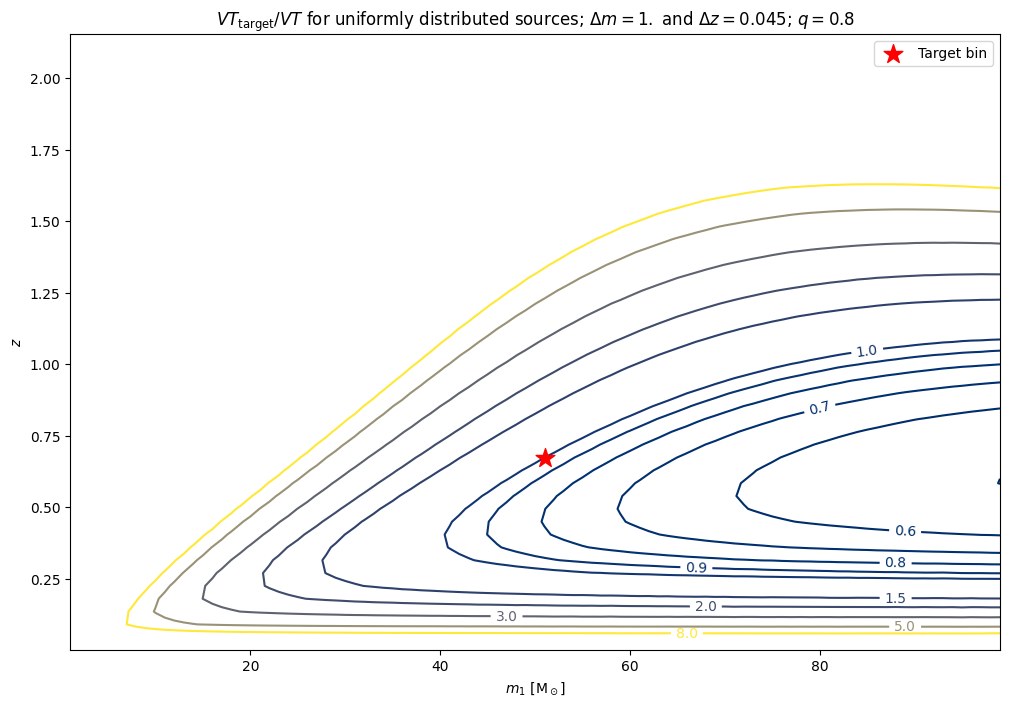

In [17]:
# # Define the target bin using its relative position in the grid
# rx, ry = 0.5, 0.3
# target_bin = (int(rx * (VT.T.shape[0] - 1)), int(ry * (VT.T.shape[1] - 1)))

target_bin = (50, 15)

target_VT = VT.T[*target_bin]
VT_ratio_map = target_VT / VT

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'${{VT}}_\text{{target}} / VT$ for uniformly distributed sources; $\Delta m = {0}$ and $\Delta z = {1}$; $q = {2}$'.format(np.format_float_positional((m1_max - m1_min) / (m1_len - 1), 3),
                                                                                                                                         np.format_float_positional((z_max - z_min) / (z_len - 1), 3),
                                                                                                                                         np.format_float_positional(q, 3)))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['cividis']
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 3, 5, 8]

cf = ax.contour(m1[:-1], z[:-1], VT_ratio_map, levels=levels, cmap=cmap)
ax.clabel(cf)

ax.scatter(m1[target_bin[0]], z[target_bin[1]], color='red', marker='*', s=200, zorder=100, label='Target bin')

ax.legend()

plt.show()